<a href="https://colab.research.google.com/github/bclee232/DLwP/blob/master/11_1Dconv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1D conv layer for IMDB
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

(train_data, train_targets), (test_data, test_targets) = imdb.load_data(
    num_words=10000
)

x_train = pad_sequences(train_data, maxlen=500)
x_test = pad_sequences(train_data, maxlen=500)

print(len(train_data), x_train.shape)

Using TensorFlow backend.


17465344/17464789 [==============================] - 0s 0us/step
25000 (25000, 500)


In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(10000, 128, input_length=500))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy',
              metrics=['acc'])
hist = model.fit(x_train, train_targets, epochs=3, batch_size=512,
                 validation_split=0.2)
# even though it's meant to be fast, it is pretty slow

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 68s 3ms/step - loss: 0.8119 - acc: 0.4987 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 2/3
20000/20000 [==============================] - 68s 3ms/step - loss: 0.6890 - acc: 0.5567 - val_loss: 0.6877 - val_acc: 0.5414
Epoch 3/3
20000/20000 [==============================] - 68s 3ms/step - loss: 0.6762 - acc: 0.6362 - val_loss: 0.6805 - val_acc: 0.5952


In [8]:
import os
import numpy as np

fname = '/content/drive/My Drive/weather_data.txt'
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
# 1D convnet
model2 = Sequential()
model2.add(Conv1D(32, 5, activation='relu', 
                  input_shape=(None, float_data.shape[-1])))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(32, 5, activation='relu'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(32, 5, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')
history = model2.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# so this is pretty fast considering more steps per epoch
# why is the val loss so low but training loss is not?

Epoch 1/20
500/500 [==============================] - 24s 48ms/step - loss: 0.3907 - val_loss: 0.1751
Epoch 2/20
500/500 [==============================] - 23s 47ms/step - loss: 0.3252 - val_loss: 0.1665
Epoch 3/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2948 - val_loss: 0.3693
Epoch 4/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2758 - val_loss: 0.1870
Epoch 5/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2637 - val_loss: 0.2283
Epoch 6/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2544 - val_loss: 0.2418
Epoch 7/20
500/500 [==============================] - 24s 47ms/step - loss: 0.2453 - val_loss: 0.2378
Epoch 8/20
500/500 [==============================] - 24s 47ms/step - loss: 0.2397 - val_loss: 0.2920
Epoch 9/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2348 - val_loss: 0.2421
Epoch 10/20
500/500 [==============================] - 23s 47ms/step - loss: 0.227

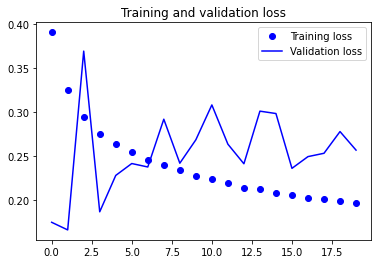

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# what is happening with my graph...

In [13]:
from keras.layers import GRU

# 1D & recurrent layers
model3 = Sequential()
model3.add(Conv1D(32, 5, activation='relu', 
                  input_shape=(None, float_data.shape[-1])))
model3.add(MaxPooling1D(3))
model3.add(Conv1D(32, 5, activation='relu'))
model3.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model3.add(Dense(1))

model3.compile(optimizer=RMSprop(), loss='mae')
history3 = model3.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)
# ok why is my training loss insane in the initial 2 epochs?
# hmmm performs pretty bad...

Epoch 1/10
100/100 [==============================] - 20s 198ms/step - loss: 2518493.6687 - val_loss: 0.5894
Epoch 2/10
100/100 [==============================] - 19s 191ms/step - loss: 1141.7646 - val_loss: 0.5446
Epoch 3/10
100/100 [==============================] - 19s 189ms/step - loss: 5.2366 - val_loss: 0.5217
Epoch 4/10
100/100 [==============================] - 19s 190ms/step - loss: 0.8701 - val_loss: 0.5175
Epoch 5/10
100/100 [==============================] - 19s 189ms/step - loss: 1.5729 - val_loss: 0.5304
Epoch 6/10
100/100 [==============================] - 19s 188ms/step - loss: 2.9566 - val_loss: 0.5312
Epoch 7/10
100/100 [==============================] - 19s 188ms/step - loss: 7.9248 - val_loss: 0.5663
Epoch 8/10
100/100 [==============================] - 19s 189ms/step - loss: 45.6201 - val_loss: 0.5920
Epoch 9/10
100/100 [==============================] - 19s 188ms/step - loss: 9.2162 - val_loss: 0.5835
Epoch 10/10
100/100 [==============================] - 19s 190m